In [1]:
!pip -q install xarray-spatial shap git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample
# Make sure git install worked
import xbatcher
print(xbatcher.__version__)

0.1.dev236+g2e721fc


In [2]:
import xarray as xr
import xrspatial
import rioxarray
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from torchmetrics.functional import mean_squared_error as torch_mse
from torchmetrics.functional import pearson_corrcoef, normalized_root_mean_squared_error
import torch
import shap
import os

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

Prepare data. Here we are trying to replicate the RF described in [Preisler et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0378112717304772) so we need to do some feature engineering to match their work.

In [3]:
# Prepare data - since we are working with tabular data here we convert
# to a dataframe.
ds = xr.open_dataset("data_working/westmort_1km.nc")
ds

<xarray.Dataset> Size: 4GB
Dimensions:      (y: 2608, x: 2360, time: 27)
Coordinates:
  * x            (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y            (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time         (time) int64 216B 1997 1998 1999 2000 ... 2020 2021 2022 2023
Data variables: (12/16)
    elev         (y, x) float32 25MB ...
    slope        (y, x) float32 25MB ...
    northness    (y, x) float32 25MB ...
    eastness     (y, x) float32 25MB ...
    fire         (time, y, x) float32 665MB ...
    prcp         (time, y, x) float32 665MB ...
    ...           ...
    abies        (y, x) float32 25MB ...
    pinus        (y, x) float64 49MB ...
    populus      (y, x) float32 25MB ...
    pseudotsuga  (y, x) float32 25MB ...
    tsuga        (y, x) float32 25MB ...
    spatial_ref  int64 8B ...

rhost: "area with host minus area with mortality prior year"

In [4]:
ds["rhost"] = (ds["treecover"] - ds["mortality"]).clip(0, 100)

36-year average precipitation. They based this off of the PRISM dataset but I think we can take a long-term average and just call it good.

In [5]:
ds["prcp_avg"] = ds.prcp.mean(dim="time")

fire: "Area affected by fire 2–4 yr prior"

In [6]:
ds["fire_roll_sum"] = ds.fire.rolling(time=3).sum()

near1: "Maximum area affected in adjacent cells"

In [7]:
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

def focal_max(arr):
    arr = arr.isel(time=0)
    return xrspatial.focal.focal_stats(arr, kernel, stats_funcs=["max"]).isel(stats=0)

ds["near1"] = ds.mortality.groupby("time").apply(focal_max)
ds["near1"]

<xarray.DataArray 'near1' (time: 27, y: 2608, x: 2360)> Size: 665MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(27, 2608, 2360), dtype=float32)
Coordinates:
  * x        (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time     (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
    stats    <U3 12B 'max'

prcp1-4: precipitation, but shifted some years prior to the year of prediction.

mort1: mortality one year prior to the year of prediction

There's a lot of shifting variables here to create the lagged covariates described in the paper. By convention *we will not modify coordinates of `mortality`, which is the prediction target*. All the covariates get shifted. Note that shifts are positive because we are moving data from the past to match the position of the mortality label.

In [8]:
ds["prcp1"]  = ds["prcp"].shift(time=1)
ds["prcp2"]  = ds["prcp"].shift(time=2)
ds["prcp3"]  = ds["prcp"].shift(time=3)
ds["prcp4"]  = ds["prcp"].shift(time=4)
ds["fire24"] = ds["fire_roll_sum"].shift(time=2)
ds["mort1"]  = ds["mortality"].shift(time=1)

Now we split the dataset into training and validation and do windowing just as we did with the Unet. This is so we can be sure that differences in model performance cannot be attributed to slight differences in training data.

In [9]:
ds_train = ds.sel(time=slice(None, 2014))
ds_valid = ds.sel(time=slice(2014, None))

def patch_filter(ds, batch, prop_valid=0.70):
    # Accept patch if the last time step has too many NaNs.
    nan_mask = ds.isel(**batch).isel(time=-1).isnull().astype(np.float32)
    
    return 1 - nan_mask.mean() >= prop_valid

input_dims = dict(x=64, y=64, time=5)
input_overlap = dict(x=24, y=24, time=4)

bgen_train = xbatcher.BatchGenerator(
    ds_train.mortality,
    input_dims=input_dims,
    input_overlap=input_overlap,
    filter_fn=patch_filter
)

bgen_valid = xbatcher.BatchGenerator(
    ds_valid.mortality,
    input_dims=input_dims,
    input_overlap=input_overlap,
    filter_fn=patch_filter
)

Now we have to "mark" what positions in the mortality array were available to the Unet.

In [10]:
mask_train = xr.full_like(ds_train.mortality, 0)
mask_valid = xr.full_like(ds_valid.mortality, 0)

for _, slices in bgen_train._batch_selectors.selectors.items():
    slices = (slices[0]["time"], slices[0]["y"], slices[0]["x"])
    mask_train.values[slices] = 1

for _, slices in bgen_valid._batch_selectors.selectors.items():
    slices = (slices[0]["time"], slices[0]["y"], slices[0]["x"])
    mask_valid.values[slices] = 1

Pull those pixels out of the dataset, grab the variables we need, and convert to dataframe.

In [11]:
vars_to_keep = ["mortality", "prcp1", "prcp2", "prcp3", "prcp4", "fire24", "mort1", "near1", "prcp_avg", "rhost"]

df_train = ds_train[vars_to_keep].where(mask_train).to_dataframe()
df_train = df_train[~df_train.mortality.isna()]

Side note: I think converting the mask to a dataframe and then subsetting rows is slightly less memory-intensive.

In [12]:
df_valid = ds_valid[vars_to_keep].to_dataframe()

In [13]:
df_valid_mask = mask_valid.to_dataframe()

In [14]:
df_valid = df_valid[df_valid_mask.mortality > 0]

In [15]:
df_valid = df_valid[~df_valid.mortality.isna()]
df_train = df_train[~df_train.mortality.isna()]

In [16]:
# Impute missing values with the median. This is close to what we did for missing values in the Unet case.
def impute_median(x):
    return x.fillna(x.median())

df_train = df_train.drop(columns="stats").apply(impute_median, axis=0)
df_valid = df_valid.drop(columns="stats").apply(impute_median, axis=0)

In [17]:
df_train.shape

(8454124, 10)

In [18]:
df_valid.shape

(5547720, 10)

Model training. As the above shapes indicate, there's a looooooot of data here. We can probably get away with using like 10% of the data.

In [19]:
def split_xy(df, target):
    return (
        df.reset_index(drop=True).drop(columns=target).to_numpy(),
        df.reset_index(drop=True)[target].to_numpy()
    )

downsample_step = 10

X_train, y_train = split_xy(df_train[::downsample_step], "mortality")
X_valid, y_valid = split_xy(df_valid[::downsample_step], "mortality")

# Make sure the index didn't leak in somehow
# Minus 1 because the target var isn't in X
assert X_train.shape[1] == len(vars_to_keep)-1

In [20]:
model = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=50)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=50, oob_score=True)

In [21]:
y_hat = model.predict(X_valid)

In [22]:
def get_results(y, y_hat):
    y = torch.tensor(y)
    y_hat = torch.tensor(y_hat)
    return {
        "mse": torch_mse(y_hat, y),
        "nrmse": normalized_root_mean_squared_error(y_hat, y),
        "r": pearson_corrcoef(y_hat, y)
    }

print("Training")
print(get_results(y_train, model.oob_prediction_))
print("Validation")
print(get_results(y_valid, y_hat))

Training
{'mse': tensor(0.5441, dtype=torch.float64), 'nrmse': tensor(3.7577, dtype=torch.float64), 'r': tensor(0.7385, dtype=torch.float64)}
Validation
{'mse': tensor(3.5272, dtype=torch.float64), 'nrmse': tensor(4.5230, dtype=torch.float64), 'r': tensor(0.7085, dtype=torch.float64)}


In [23]:
# Now run SHAP on both models.
# Use kmeans to sample the background so we know we reproduce the distribution
# of the input data.
X_valid_sample = shap.kmeans(X_valid, 50).data

names = vars_to_keep[1:]

ke = shap.KernelExplainer(lambda x: model.predict(x), X_valid_sample, feature_names=names)
shap_result = ke(X_valid_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


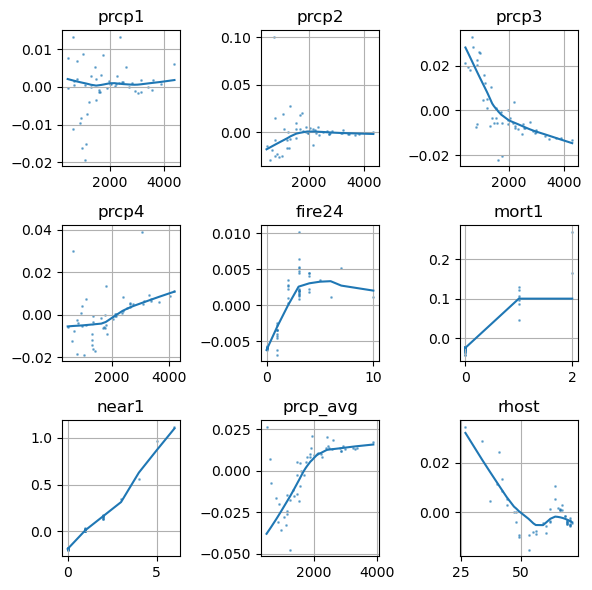

In [24]:
# Plot SHAP for both models on all features, with lowess smooth
import statsmodels.api as sm

fig, axes = plt.subplots(3, 3, sharey=False, sharex=False, figsize=(6, 6))

for i, (name, ax) in enumerate(zip(names, axes.flat)):
    smooth = sm.nonparametric.lowess(exog=shap_result.data[:, i], endog=shap_result.values[:, i])
    ax.scatter(shap_result.data[:, i], shap_result.values[:, i], s=1, alpha=0.5)
    ax.plot(smooth[:, 0], smooth[:, 1])
    ax.grid()
    ax.set_title(name)

fig.tight_layout()
plt.show()

In [25]:
util.training.get_final_metrics("logs/06202025_damage_unet_64x64x5/lightning_logs/version_0/")

{'lr-Adam': 0.0010000000474974513,
 'valid_loss': 3.8261215686798096,
 'valid_nrmse': 3.9612643718719482,
 'valid_corr': 0.1828755885362625,
 'epoch': 17.0,
 'train_loss': 1.130355954170227,
 'train_nrmse': 2.1703121662139893,
 'train_corr': 0.2682033181190491,
 'train_lastobs_loss': 5.880587100982666,
 'train_lastobs_corr': 0.1773812472820282,
 'train_lastobs_nrmse': 8.174294471740723,
 'train_timeavg_loss': 5.880587100982666,
 'train_timeavg_corr': 0.1773812472820282,
 'train_timeavg_nrmse': 8.174294471740723,
 'valid_lastobs_loss': 5.880587100982666,
 'valid_lastobs_corr': 0.1773812472820282,
 'valid_lastobs_nrmse': 8.174294471740723,
 'valid_timeavg_loss': 5.880587100982666,
 'valid_timeavg_corr': 0.1773812472820282,
 'valid_timeavg_nrmse': 8.174294471740723}